# Tracé des RVI, cohérence entre radar et optique (RVI vs. FCOVER)
Le RVI est un indicateur de végétation calculé à partir des données SAR. Le but de ce code est de montrer sa cohérence avec l'indicateur optique de couverture végétale FCOVER.

In [52]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from scipy.stats import kendalltau, iqr, spearmanr, pearsonr
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans

import esg_deforestation_radar as sentinel

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
from matplotlib.patches import Rectangle
%matplotlib inline


plt.rcParams["figure.figsize"] = (9,6)

In [53]:
%reload_ext autoreload
%autoreload 2

Le répertoire source contient la zone d'intérêt, les fichiers SAFE .zip téléchargés et un fichier JSON: "geozone.json" qui décrit les éléments de décompression et la partie à extraire.

In [54]:
# Choix d'une zone à étudier.
target = "../data/Barro-Alto"
zone = sentinel.getzone(target)
zone

{'name': 'Barro Alto - Nickel (Brasil)',
 'bbox': [-15.12, -49.06, -15.02, -48.92],
 'step': 10,
 'GRD': '/Volumes/JLTD/Sentinel/GRD/Barro-Alto',
 'FCOVER': '/Volumes/JLTD/Sentinel/FCOVER',
 'NDVI': '/Volumes/JLTD/Sentinel/NDVI',
 'target': '../data/Barro-Alto'}

La cellule suivante doit être décommentée si vous avez des données brutes et que vous souhaitez les recharger. Sinon, le code utilisera les données préchargées stockées dans les fichiers CSV.

In [28]:
sentinel.rvicompute(zone,renew=True)

Barro-Alto:   0%|          | 0/119 [00:00<?, ?it/s]

In [55]:
# Récupération des calculs de RVI.
R = sentinel.dataset.rvi(zone)
R

,RVI,RMSE,INCIDENCE,ELEVATION,DIRECTION,DLAT,DLON,DX,DY,ZIPFILE,RVIC
DATE,,,,,,,,,,,
2019-04-08,2.022880,0.014757,45.177209,39.718881,-1,0.348049,-1.002555,11381.5,-1208.0,S1A_IW_GRDH_1SDV_20190408T084503_20190408T0845...,2.026044
2019-04-13,2.030516,0.020464,32.315486,28.789817,-1,0.059303,0.987514,-10136.0,-3043.0,S1A_IW_GRDH_1SDV_20190413T085312_20190413T0853...,2.026746
2019-04-20,2.022383,0.014615,45.171332,39.713658,-1,0.347935,-1.002663,11390.0,-1208.0,S1A_IW_GRDH_1SDV_20190420T084504_20190420T0845...,2.026234
2019-04-25,2.028855,0.018965,32.306826,28.782296,-1,0.059273,0.988726,-10146.0,-3043.0,S1A_IW_GRDH_1SDV_20190425T085313_20190425T0853...,2.026005
2019-05-02,2.021148,0.013618,45.172762,39.714986,-1,0.347987,-1.002477,11380.5,-1208.0,S1A_IW_GRDH_1SDV_20190502T084504_20190502T0845...,2.025450
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-21,2.030892,0.020029,32.322200,28.796255,-1,0.059660,0.986892,-10149.5,-3040.0,S1A_IW_GRDH_1SDV_20210321T085324_20210321T0853...,2.026628
2021-03-28,2.021824,0.013522,45.171278,39.712921,-1,0.348439,-1.001935,11406.5,-1210.0,S1A_IW_GRDH_1SDV_20210328T084515_20210328T0845...,2.026228
2021-04-02,2.029271,0.019255,32.323584,28.797431,-1,0.059747,0.986596,-10144.5,-3040.0,S1A_IW_GRDH_1SDV_20210402T085324_20210402T0853...,2.026165


DX et DY correspondent aux coordonnées du vecteur reliant le centre de la fenêtre d'acquisition au centre du masque étudié. L'affichage suivant montre que les images successives ne sont pas sytématiquement toutes positionnées au même endroit par rapport à notre zone d'intérêt.

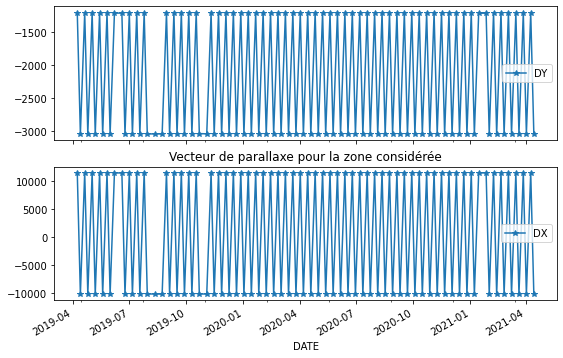

In [56]:
# Affichage des effets de parallaxe.
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
R['DX'].plot(style='-*',ax=ax2, legend=True)
R['DY'].plot(style='-*',ax=ax1, legend=True)
plt.title("Vecteur de parallaxe pour la zone considérée");

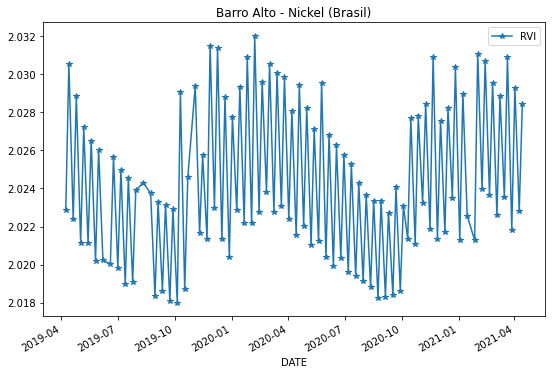

In [57]:
# Affichage du RVI.
R['RVI'].plot(style='-*',legend=True)
plt.title(zone['name']);

### Réglage de la parallaxe

Les calculs suivants démontrent ce que réalise la fonction `rvicorrect()` qui calcule un RVI corrigé de parallaxe et lissé.
Dans un premier temps on repère les clusters, puis on interpole les données pour avoir une position moyenne sur laquelle on va se projeter.
L'algorithme de correction est un peu trivial. On aurai pu aussi reprendre les suggestions de SPAN, mais cela semble un peu compliqué pour juste une toute petite fenêtre.

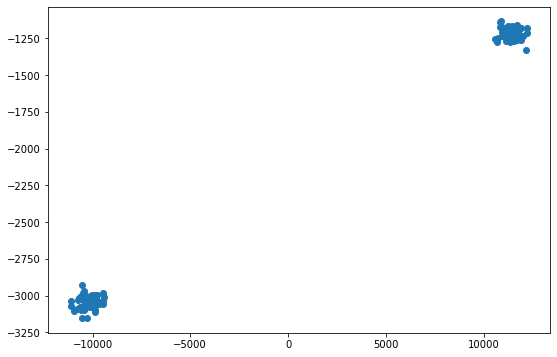

In [58]:
# On affiche les clusters de (DX,DY) avec un peu de bruit.
dx = R['DX'].copy()
dx += np.random.randn(len(dx))*iqr(dx)/50
dy = R['DY'].copy()
dy += np.random.randn(len(dy))*iqr(dy)/50
plt.scatter(dx,dy)

K = 2


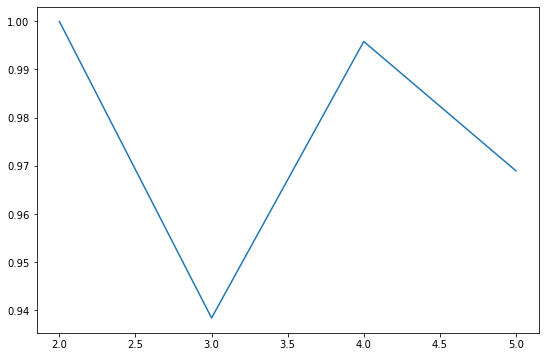

In [59]:
# On propose un calcul simple du nombre de clusters.
DXY = R[['DX','DY']]
N = 6
X = np.arange(2,N)
S = np.ones(N-2)
#fig,axes = plt.subplots(N,1)
for K in range(2,N):
    km = KMeans(K).fit(DXY)
    P = [np.sum(km.labels_==k)/len(DXY) for k in range(K)]
    L = -np.sum(P*np.log(P))
    S[K-2] = L/np.log(K)
plt.plot(X,S)
K = X[np.argmax(S)]
print("K =",K)

Pour chaque cluster on calcule la valeur et on moyenne en fonction du nombre de points par cluster.

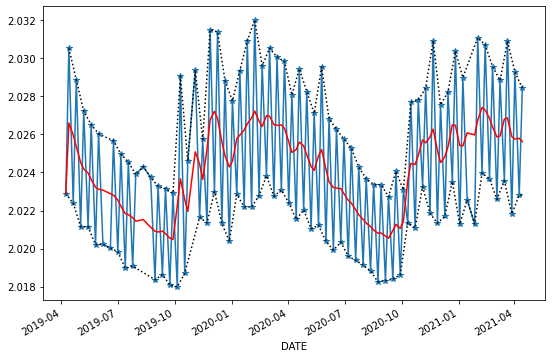

In [60]:
# Calcul d'un signal moyen et d'un écart à cette moyenne.
km = KMeans(K).fit(DXY)
P = [np.sum(km.labels_==k)/len(DXY) for k in range(K)]
LR = []
R['RVI'].plot(style='-*')
for k in range(K):
    rvi0 = R['RVI'].copy()
    rvi0.loc[km.labels_ != k] = np.nan
    rvi0.interpolate(method='index',inplace=True)
    rvi0.plot(style='k:')
    LR.append(rvi0)
    
R['DL'] = km.labels_
R['RVIM'] = np.nanmean(LR,axis=0) #np.dot(P,LR) #
R['RVIM0'] = np.nanmin(LR,axis=0)
R['RVIM1'] = np.nanmax(LR,axis=0)
R['RVIM'].plot(style='r-')

R['DRVI'] = R['RVIM']-R['RVI']

In [61]:
# Finalement, on recherche les coefficients de correction.
res = smf.ols('DRVI ~ DX*DY', data=R).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DRVI   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     697.5
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           1.38e-73
Time:                        19:42:20   Log-Likelihood:                 686.81
No. Observations:                 119   AIC:                            -1366.
Df Residuals:                     115   BIC:                            -1354.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0252      0.080     -0.316      0.753      -0.183       0.132
DX          2.528e-06   6.59e-06      0.384      0.702   -1.05e-05    1.56e-05
DY         -8.083e-06   3.26e-05     -0.248      0.805   -7.26e-05    5.65e-05
DX:DY       7.438e-10   2.68e-09      0.277      0.782   -4.57e-09    6.06e-09
==============================================================================
Omnibus:                       19.196   Durbin-Watson:                   2.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.844
Skew:                          -0.802   Prob(JB):                     8.99e-07
Kurtosis:                       4.744   Cond. No.                     2.72e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='DATE'>

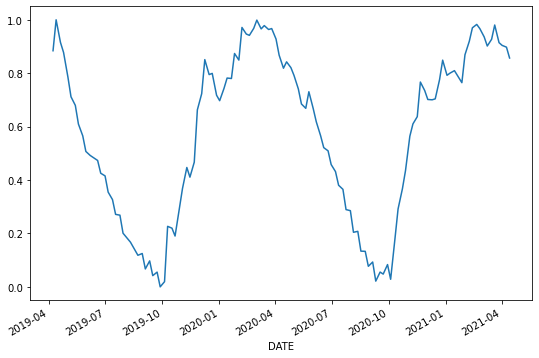

In [62]:
# La valeur conservée est la projection avec ces coefficients, 
# lissée par un filtre exponentiel. 
R['RVIC'] = R['RVI']+res.predict(R)
R['RVIC'] = R['RVIC'].ewm(alpha=0.25).mean()

# On affiche une version normalisée.
y = R['RVIC'].copy()
y = (y-y.min())/(y.max()-y.min())
y.plot()

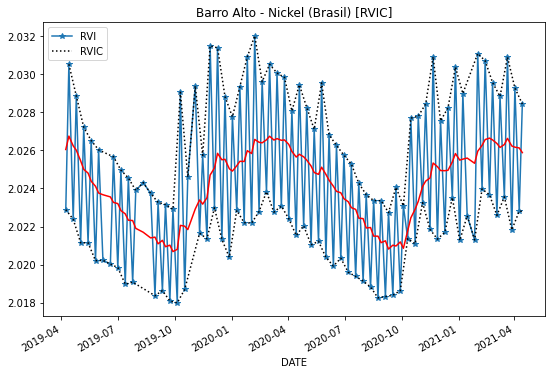

In [63]:
# Tous ces calculs sont aussi effectués par rvicorrect().
R = sentinel.dataset.rvicorrect(zone,plot=True)

## Récupération de FCOVER

La ligne suivante est à décommenter si vous souhaitez recharger des données depuis une source nouvellement acquise.

In [64]:
#sentinel.glscompute(zone,'FCOVER')

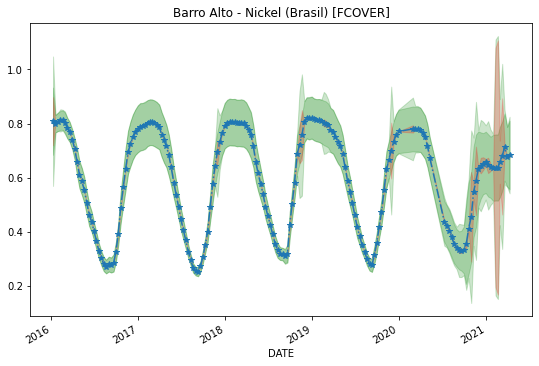

In [65]:
sentinel.dataset.glsplot(zone,'FCOVER')

## Cohérence entre RVI et FCOVER
On cherche à vérifier que RVI et FCOVER évoluent de manière cohérente.

On pratique une transformation affine de RVIC pour qu'elle colle au mieux sur FCOVER. Pour cela on utilise une régresssion linéaire pondérée inversement proportionnelle à l'écart type corrigé par le nombre de points manquants (tube rouge).

Le résultat est un dictionnaire de corrélations, PR est la proportion de points dans le tube rouge.

{'NAME': 'Barro Alto - Nickel (Brasil)',
 'PR': 0.8403361344537815,
 'R2': 0.9072552487238493,
 'PEARSON': 0.9324097467949448,
 'KENDALL': 0.724255804016522}

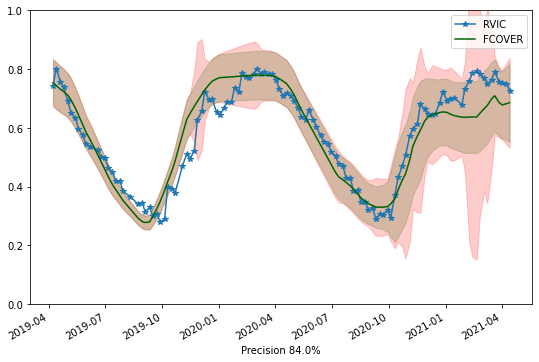

In [66]:
sentinel.dataset.rvicompare(zone,'FCOVER', plotind=True, plotrvi=True)

In [67]:
# On récupère la liste de toutes les zone <target> à traiter.
datadir = '../data'
ind = 'FCOVER'
listdir = [os.path.join(datadir,d) for d in os.listdir('../data') 
           if os.path.exists(os.path.join(datadir,d,'geozone.json'))]
listdir

['../data/Brunswick',
 '../data/Onca-Puma',
 '../data/Sierra-Mojada',
 '../data/Cerro-Matoso',
 '../data/Barro-Alto',
 '../data/Morro-da-Mina',
 "../data/Voisey's-Bay",
 '../data/Totten',
 '../data/Heath-Steele',
 '../data/South-Walker-Creek',
 '../data/Moatize-Mozambique']

In [68]:
import ipywidgets as widgets

def plotzone(target):
    zone = sentinel.getzone(target)
    plt.figure(figsize=(14,16))
    sentinel.dataset.zoneplot(zone,'FCOVER')
    
widgets.interact(plotzone, target=listdir);

interactive(children=(Dropdown(description='target', options=('../data/Brunswick', '../data/Onca-Puma', '../da…

_Jérôme Lacaille_